# Class 3: Color Perception and Color Models

## Preliminaries

Run the cell below to download the course library and class resources.

In [1]:
import gdown

gdown.download(id='1SzvuBYIZ407c9eOChXD48NG94v7azJby')
gdown.download(id='1DzD1_1xsrKPSPe62w9PeiwrUfsKfQjPI')

!unzip -o '03.zip'
!rm '03.zip'

Downloading...
From (original): https://drive.google.com/uc?id=1SzvuBYIZ407c9eOChXD48NG94v7azJby
From (redirected): https://drive.google.com/uc?id=1SzvuBYIZ407c9eOChXD48NG94v7azJby&confirm=t&uuid=9360b49f-2a53-4772-9d89-8b53d266162b
To: /content/sdx.py
100%|██████████| 2.83k/2.83k [00:00<00:00, 7.51MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DzD1_1xsrKPSPe62w9PeiwrUfsKfQjPI
To: /content/03.zip
100%|██████████| 160k/160k [00:00<00:00, 52.1MB/s]

Archive:  03.zip
  inflating: insper.png              


Run the cell below to import the class modules.

If you get import warnings, try using **`Ctrl+M .`** to restart the kernel. *(notice there is a dot there)*

In [2]:
import numpy as np
import cv2 as cv

from sdx import *

## Loading and displaying the image

Let's load the same image used in Class 1.

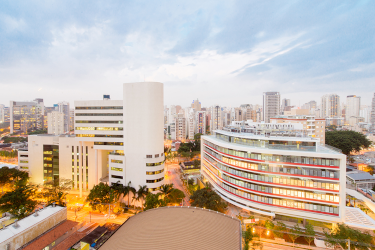

In [3]:
image = cv_imread('insper.png')

cv_imshow(image)

But, this time, we will not convert it to gray level. We will consider the original, three-dimensional array. The third dimension represents the color channels, which are three, as we have seen in the briefing.

In [4]:
height, width, channels = image.shape

print(f'{height}x{width}x{channels}')

250x375x3


Curiously enough, the order of the channels in OpenCV is BGR, and not RGB as expected, due to historical reasons. [They are not proud of it.](https://learnopencv.com/why-does-opencv-use-bgr-color-format/)

## Segmenting the sky

In Class 1, we did some recognition/classification (dark or bright) and detection (template matching). Let's no do some of the only remaining problem: segmentation.

In particular, we will try to segment the sky in the Insper picture.

### Using the original BGR color space.

 As a first attempt, we will try to identify all pixels that are close to the [cyan](https://en.wikipedia.org/wiki/Cyan) color, which seems to be a reasonable heuristic.

In [5]:
cyan = (255, 255, 0)

Let's start by using NumPy to define an [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) function for normalized BGR pixels.

In [6]:
def distance(a, b):
    return np.linalg.norm((b - a) / 255)

Now, we will use this function to identify all pixels within a distance threshold from the cyan color. In segmentation, it is very common to use a binary image (only pure black and pure white pixels) to visualize the results.

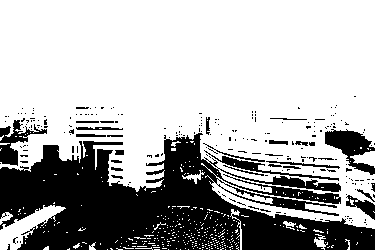

In [15]:
output = np.zeros((height, width))

for y in range(height):
    for x in range(width):
        if distance(image[y, x], cyan) < 1:
            output[y, x] = 255

cv_imshow(output)

That's... uh... not good. We either select too many pixels or too few pixels.

### Using the HSV color space

We already seen color conversion in Class 1. To convert BGR to HSV, we simply need to call `cv.cvtColor` with a different constant.

In [8]:
hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)

#### Activity 1

Before attempting a segmentation, let's normalize the values.

Read the [BGR to HSV documentation](https://docs.opencv.org/4.x/de/d25/imgproc_color_conversions.html#color_convert_rgb_hsv) and write a function that returns a `(h, s, v)` tuple such that:

* `h` is an integer in the `[0, 360]` interval;

* `s` is a float in the `[0, 1]` interval;

* `v` is a float in the `[0, 1]` interval.

In [17]:
def normalize_hsv(pixel):
    return pixel[0]*2, pixel[1]/255, pixel[2]/255 # replace this line with your code

In [20]:
def hsv_distance(h, s, v, ho, so, vo):
  hd = (ho - h)/360
  sd = (so - s)/255
  vd = (vo - v)/255
  return (hd + sd + vd)/3

Now try to use the normalized values to segment the sky as best as you can.

Google provides a simple [color picker](https://www.google.com/search?q=color+picker) that might help.

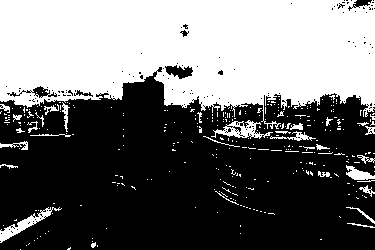

In [61]:
output = np.zeros((height, width))

hc = [194, 150, 130]

for y in range(height):
    for x in range(width):
        h, s, v = normalize_hsv(hsv[y, x])
        if hsv_distance(h, s, v, hc[0], hc[1], hc[2]) < 0.92:
            output[y, x] = 255

cv_imshow(output)

### Using the HLS color space

Now let's convert BGR to HLS. OpenCV uses HLS instead of HSL because... I have no idea and, at this point, stopped caring. Just roll with it.

In [36]:
hls = cv.cvtColor(image, cv.COLOR_BGR2HLS)

#### Activity 2

Again, let's normalize the values.

Read the [BGR to HLS documentation](https://docs.opencv.org/4.x/de/d25/imgproc_color_conversions.html#color_convert_rgb_hls) and write a function that returns a `(h, l, s)` tuple such that:

* `h` is an integer in the `[0, 360]` interval;

* `l` is a float in the `[0, 1]` interval;

* `s` is a float in the `[0, 1]` interval.

In [37]:
def normalize_hls(pixel):
    return pixel[0]*2, pixel[1]/255, pixel[2]/255 # replace this line with your code

Again, try to use the normalized values to segment the sky as best as you can.

You can use the color picker again, but shouldn't be necessary.

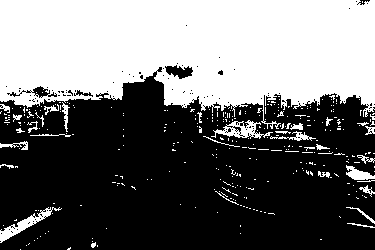

In [66]:
output = np.zeros((height, width))
hls_c = [194, 130, 150]
for y in range(height):
    for x in range(width):
        h, l, s = normalize_hls(hls[y, x])
        if hsv_distance(h, l, s, hls_c[0], hls_c[1], hls_c[2]) < 0.92:
            output[y, x] = 255

cv_imshow(output)

## Converting to gray level

One question remains: what exactly is the procedure to convert from BGR to gray level?

We can call the `cv.split` function to obtain each channel as an independent gray level image.

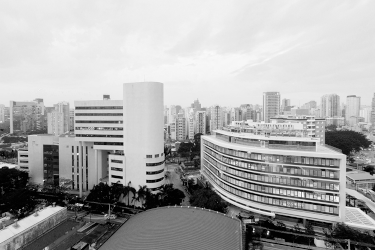

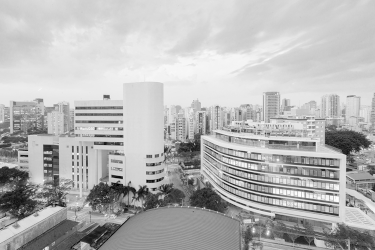

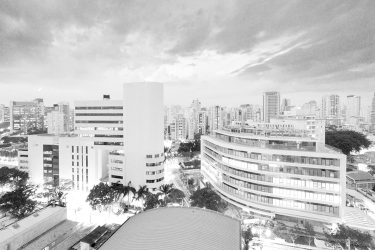

In [48]:
b, g, r = cv.split(image)

cv_imshow(b)
cv_imshow(g)
cv_imshow(r)

A possible approach to convert the original colors to gray levels is to take the average of the channels.

For efficiency, we will do this with standard NumPy arithmetic instead of loops.

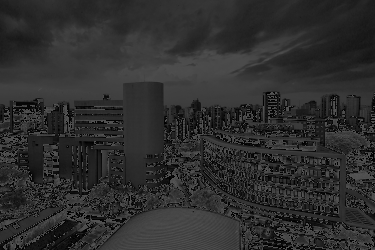

In [49]:
gray = (b + g + r) / 3

cv_imshow(gray)

### Activity 3

Something clearly went wrong in the attempt above: there are weird artifacts all over the image.

Try to figure out what was the problem and replace the code below with a fixed version.

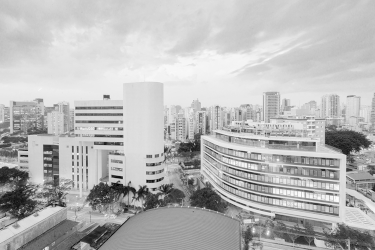

In [72]:
gray = (0.299*r+0.587*g+0.114*b)

cv_imshow(gray)

Even if you succeed, you might notice that the result is slightly (the difference is very subtle, but exists) different from what OpenCV gives us.

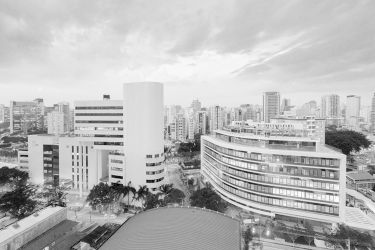

In [74]:
cv_imshow(cv.cvtColor(image, cv.COLOR_BGR2GRAY))

Try to research what OpenCV does and implement the procedure below. More importantly, **try to discover why they do it this way**.

*(write your answer here)*

You can click on the toc.png tab to the left to browse by section.